<a href="https://colab.research.google.com/github/ashishsubedi/FACE-VERIFICATION-TF/blob/master/FACEVERIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing essential libraries

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Concatenate,Dense, Subtract,Flatten,Lambda
import matplotlib.pyplot as plt
import cv2
from  scipy import ndimage

Using this to load tensorboard extension to visualize training and testing stages

In [0]:
%load_ext tensorboard

In [3]:
tf.__version__

'2.2.0-rc2'

## We are using LFW face dataset. For more info http://vis-www.cs.umass.edu/lfw/


In [4]:
!curl -O http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xzvf lfw.tgz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Aiken/Clay_Aiken_000

## Defining Function to easily visualize images

In [0]:
def show(image, label):
  plt.figure()
  plt.imshow(image[0])
  # plt.title(labels[label])
  plt.title(label)
  plt.axis('off')


Most contains only one image per person. So we are separating whole dataset such that all folders containing more than one images per person are included in training set

In [5]:
import os
import random
BASE_PATH = 'lfw'

labels = [i for i in os.listdir(BASE_PATH)]
paths_with_more_than_2_images = []

train_labels = [i for i in labels if len(os.listdir(os.path.join(BASE_PATH,i)))>=2]
test_labels = list(set(labels)-set(train_labels))
print(len(train_labels),len(test_labels))

1680 4069


# Custom Data Generator

We are building custom data Generator. It creates pipeline to load images and augment it if necessary
We'll be using Triplet Loss as our loss function. It needs three inputs and no labels are required. But we'll be generating numpy arrays of 1 as our labels as Keras.fit() requires that to be provided as well. Below, batch_labels is just our dummy variable


In [0]:
def tripletDataGenerator(labels,batch_size=32,training=True):
  #length of total data
  n = len(labels) 
  #Creating indices variable that list total lists of indices. Used to shuffle data later
  incides = np.arange(n)
  # steps = n/batch_size

  i=0
  # Creating the images batches to feed into network
  batch_a = np.zeros((batch_size,224,224,3),dtype=np.float32)
  batch_p = np.zeros((batch_size,224,224,3),dtype=np.float32)
  batch_n = np.zeros((batch_size,224,224,3),dtype=np.float32)

  #Dummy label variable
  batch_label = np.ones((batch_size),dtype=np.float32)

  while True:
    np.random.shuffle(incides)
    next_batch = incides[i*batch_size:(i+1)*batch_size]
    for j, idx in enumerate(next_batch):
      
      # Selecting Random Label for negative images. 
      rand_val = np.random.randint(n)
      while (rand_val == idx):
        rand_val = np.random.randint(n)

      n_label = labels[rand_val]

      label = labels[idx]
      files = os.listdir(os.path.join(BASE_PATH,label))

      # Selecting first image in the folder as anchor image and last image as positive image

      a_image_path = os.path.join(BASE_PATH,label,files[0])
      p_image_path = os.path.join(BASE_PATH,label,files[-1])

      n_image_path = os.path.join(BASE_PATH,n_label,np.random.choice(os.listdir(os.path.join(BASE_PATH,n_label))))
  

      if training:
        
        #For Training loading, normalizing and augement if neceesay and adding to the batch

        img1 = plt.imread(a_image_path)
        img1 = cv2.resize(img1,(224,224))
        
        img1 = img1.astype(np.float32)/255.
        batch_a[j] = img1

        img2 = plt.imread(p_image_path)
        img2 = ndimage.rotate(img2,np.random.randint(-10,10))
        img2 = cv2.resize(img2,(224,224))
        img2 = img2.astype(np.float32)/255.
        batch_p[j] = img2
    
      

        img3 = plt.imread(n_image_path)
        img3 = cv2.resize(img3,(224,224))
        img3 = img3.astype(np.float32)/255.
        batch_n[j] = img3

        

      else:
        img1 = plt.imread(a_image_path)
        img1 = cv2.resize(img1,(224,224))
        
        img1 = img1.astype(np.float32)/255.
        batch_a[j] = img1

        img2 = plt.imread(p_image_path)
        img2 = cv2.resize(img2,(224,224))
        
        img2 = img2.astype(np.float32)/255.
        batch_p[j] = img2
    
      

        img3 = plt.imread(n_image_path)
        img3 = cv2.resize(img3,(224,224))
    
        img3 = img3.astype(np.float32)/255.
        batch_n[j] = img3


    yield (batch_a,batch_p,batch_n),batch_label




In [0]:
def generate():
  return next(tripletDataGenerator(labels))

(32, 224, 224, 3)


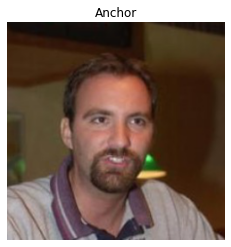

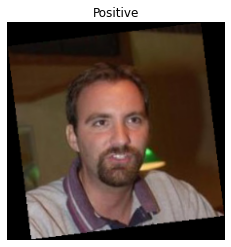

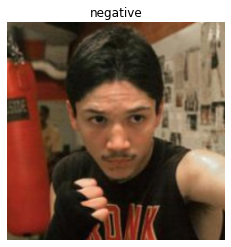

In [8]:
data = next(tripletDataGenerator(labels))
print(data[0][0].shape)
a = data[0][0]
p = data[0][1]
n = data[0][2]
show(a,'Anchor')
show(p,'Positive')
show(n,"negative")


# Build Model

In [0]:
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop()

In [0]:
def triplet_loss(y_true,x, alpha = 0.2):
  # Triplet Loss function.
  '''
      Our model output layer merges three output Embeddings into single each of size 64. So we are separating using the value.
  '''
  anchor = x[:,0:64]
  positive = x[:,64:128]
  negative = x[:,128:]

  # distance between the anchor and the positive
  pos_dist = tf.keras.backend.sum(tf.keras.backend.square(anchor-positive),axis=1)
  # distance between the anchor and the negative
  neg_dist = tf.keras.backend.sum(tf.keras.backend.square(anchor-negative),axis=1)
  # compute loss
  basic_loss = pos_dist-neg_dist+alpha
  loss = tf.keras.backend.maximum(basic_loss,0.0)
  return loss


We'll be using VGG16 as our encoder model

We'll have two model. First one a base_model which just takes inputs of given shape and outputs embedding of size 64.
Our Complete model will use this base model to feed input and outputs will be merged.
Doing this, we can reuse our base model for inference with slight modification

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
def buildEmbeddingModel():
  
  vgg =  VGG16(False,'imagenet',input_shape=(224,224,3))
  vgg.trainable = False
  h1 = Flatten(name='Flatten')(vgg.output)
  output = Dense(64,name='Output_Embedding',kernel_regularizer=tf.keras.regularizers.l2(1e-3))(h1)

  model = tf.keras.Model(inputs=[vgg.input],outputs=[output],name="Face_Recog")
  return model


In [0]:
def complete_model(base_model):
  input1 = Input(shape=(224,224,3),name='Input_1')
  input2 = Input(shape=(224,224,3),name="Input_2")
  input3 = Input(shape=(224,224,3),name='Input_3')
  A = base_model(input1)
  P = base_model(input2)
  N = base_model(input3)
  output = Concatenate(name='Merged')([A,P,N])
  model = tf.keras.Model(inputs=[input1, input2, input3], outputs=output)
  model.compile(loss=triplet_loss, optimizer=tf.keras.optimizers.RMSprop(0.001))

  return model

In [13]:
base_model=buildEmbeddingModel()
model = complete_model(base_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Face_Recog (Model)              (None, 64)           16320384    Input_1[0][0]                    
                                                                 Input_2[0][0]                

This is how our complete model looks like. Face_Recog Model is our base model and complete model just adds inputs and outputs layer

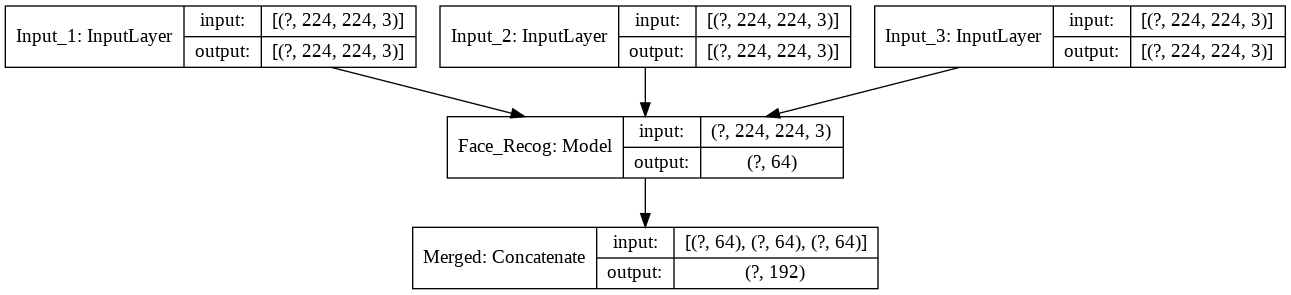

In [14]:
tf.keras.utils.plot_model(model,'model_plot.png',show_shapes=True)

# Training
Importing following callbacks for easiness.
TensorBoard is use to visualize our training process.
ModelCheckpoint saves our model training status and allows us to continue re-training from where we left off

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

Uncomment this incase your tensorboard scalars are clustered by training for many times

In [0]:
#!rm -rf model
#!rm -rf logs

In [0]:
%tensorboard --logdir logs 

<IPython.core.display.Javascript object>

# Training Using Keras fit method

In [17]:
model.fit(tripletDataGenerator(train_labels,training=True),epochs=20,callbacks=[TensorBoard('./logs'),ModelCheckpoint('./model',save_best_only=True)],steps_per_epoch=200,verbose=1,validation_data=tripletDataGenerator(labels,training=False),validation_steps=30)

Epoch 1/20
  9/200 [>.............................] - ETA: 3:17 - loss: 330.1386

KeyboardInterrupt: ignored

# Training Using custom gradient tape method


Use any one of two methods to train your model. For easiness, I prefer using keras fit. But for more flexibility, custom method is prefered.


In [0]:
import sys
import time

def step(dataGenerator,labels,BS):
  #Generating next batch of trainign data
  X,y = next(dataGenerator(labels,batch_size=BS))
	# keep track of our gradients
  with tf.GradientTape() as tape: 
    
    pred = model((X[0],X[1],X[2]))
    #Calculating Triplet Loss
    loss = triplet_loss(y, pred)
    
  #Calculating gradinents of all trainable parameters
  grads = tape.gradient(loss, model.trainable_variables)
  #Appling gradient optimization step
  opt.apply_gradients(zip(grads, model.trainable_variables))
  return np.mean(loss)

In [182]:
# compute the number of batch updates per epoch
EPOCHS = 20
BS = 16
numUpdates = int(len(train_labels) / BS)
# loop over the number of epochs
for epoch in range(0, EPOCHS):
# show the current epoch number
  print("[INFO] starting epoch {}/{}...".format(
    epoch + 1, EPOCHS), end="")
  sys.stdout.flush()
  epochStart = time.time()
  loss = 0
  # loop over the data in batch size increments
  for i in range(0, numUpdates):
    loss = step(tripletDataGenerator,train_labels,BS)
  print("LOSS: "+ str(loss))
  sys.stdout.flush()
  # show timing information for the epoch
  epochEnd = time.time()
  elapsed = (epochEnd - epochStart) / 60.0
  print("took {:.4} minutes".format(elapsed))

[INFO] starting epoch 1/20...LOSS: 0.0
took 2.976 minutes
[INFO] starting epoch 2/20...LOSS: 9.755015
took 2.992 minutes
[INFO] starting epoch 3/20...LOSS: 0.0
took 2.986 minutes
[INFO] starting epoch 4/20...LOSS: 0.0
took 2.997 minutes
[INFO] starting epoch 5/20...LOSS: 0.0
took 2.992 minutes
[INFO] starting epoch 6/20...

KeyboardInterrupt: ignored

In [183]:
base_model.save('base_model.h5')
base_model.save('saved_model/base_model')

INFO:tensorflow:Assets written to: saved_model/base_model/assets
INFO:tensorflow:Assets written to: saved_mode/model/assets


# Inference

In [0]:
def dist(inputs):
  x1,x2= inputs
  return spatial.distance.cosine(x1,x2)

We again utilize our trained base model and reuse it to have different sets of inputs and outputs. This is the reason we created base model separately.  
Our inference model has two inputs and two outputs. We can modifiy inputs and outputs as required.

In [184]:
def build_inference_model():

  input1 = Input(shape=(224,224,3),name='Input_1')
  input2 = Input(shape=(224,224,3),name="Input_2")
  x1 = base_model(input1)
  x2 = base_model(input2)
  model = tf.keras.Model(inputs=[input1, input2], outputs=[x1,x2])
  return model
  
inference_model = build_inference_model()
inference_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Face_Recog (Model)              (None, 64)           16320384    Input_1[0][0]                    
                                                                 Input_2[0][0]                    
Total params: 16,320,384
Trainable params: 1,605,696
Non-trainable params: 14,714,688
__________________________________________________________________________________________________


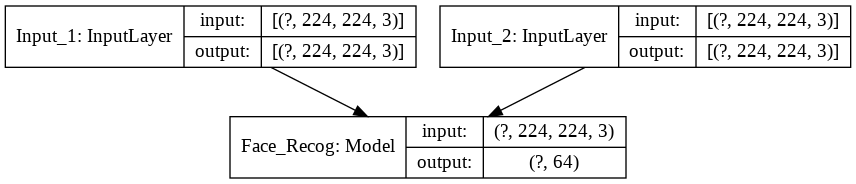

In [185]:
tf.keras.utils.plot_model(inference_model,'inference_model_plot.png',show_shapes=True)

Preprocessing images before inference

In [0]:
def preprocess(img1,img2):
  img1 = cv2.resize(img1,(224,224))
  img1.astype(np.float32)/255.

  img2 = cv2.resize(img2,(224,224))
  img2.astype(np.float32)/255.
  
  img1 = img1.reshape(-1,224,224,3)
  img2 = img2.reshape(-1,224,224,3)
  return img1,img2

Calculating the cosine difference between two method.  
L2 Norm is normally used but for me this gave the best result

In [0]:
from scipy import spatial
def inference(inputs):
  img1,img2 = inputs
  img1,img2 = preprocess(img1,img2)
  x1,x2 = inference_model.predict((img1,img2))
  dist = spatial.distance.cosine(x1, x2)
  print(dist)
  if(dist<0.5):
    print("SAME")
  else:
    print("DIFFERENT")

In [94]:
inference_model.save('inference_model.h5')
inference_model.save('saved_inference_model/inference_model')

INFO:tensorflow:Assets written to: saved_inference_model/inference_model/assets


If you need inference model saved model format

In [0]:
!zip -r /content/file.zip /content/saved_inference_model
!zip -r /content/base_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/base_model/ (stored 0%)
  adding: content/saved_model/base_model/variables/ (stored 0%)
  adding: content/saved_model/base_model/variables/variables.index (deflated 68%)
  adding: content/saved_model/base_model/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: content/saved_model/base_model/variables/variables.data-00000-of-00002 (deflated 81%)
  adding: content/saved_model/base_model/assets/ (stored 0%)
  adding: content/saved_model/base_model/saved_model.pb (deflated 91%)


# Testing Model

## SAME

In [225]:
label = np.random.choice(os.listdir(BASE_PATH))
print(os.listdir(os.path.join(BASE_PATH,label)))
image_path = os.path.join(BASE_PATH,label,os.listdir(os.path.join(BASE_PATH,label))[0])
another_image_path = os.path.join(BASE_PATH,label,os.listdir(os.path.join(BASE_PATH,label))[-1])
img1 = plt.imread(image_path)
img2 = plt.imread(another_image_path)
print(image_path,another_image_path)
print(img1.shape)

['Patrick_Roy_0002.jpg', 'Patrick_Roy_0001.jpg']
lfw/Patrick_Roy/Patrick_Roy_0002.jpg lfw/Patrick_Roy/Patrick_Roy_0001.jpg
(250, 250, 3)


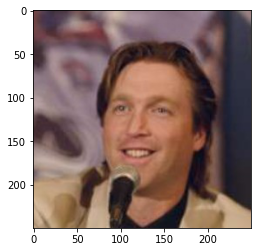

In [229]:
img1 = cv2.flip( img1, 1 )

plt.imshow(img1)


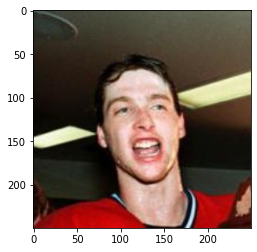

In [230]:
plt.imshow(img2)


In [231]:
inference((img1,img2))

0.42718571424484253
SAME


# Different

In [194]:
label = np.random.choice(os.listdir(BASE_PATH))
label2 = np.random.choice(os.listdir(BASE_PATH))
image_path = os.path.join(BASE_PATH,label,np.random.choice(os.listdir(os.path.join(BASE_PATH,label))))
another_image_path = os.path.join(BASE_PATH,label2,np.random.choice(os.listdir(os.path.join(BASE_PATH,label2))))
img1 = plt.imread(image_path)
img2 = plt.imread(another_image_path)
print(image_path,another_image_path)
print(img1.shape)

lfw/Frederique_van_der_Wal/Frederique_van_der_Wal_0001.jpg lfw/Roger_Federer/Roger_Federer_0010.jpg
(250, 250, 3)


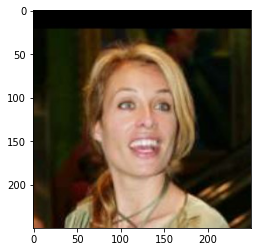

In [202]:
# horizontal_img1 = cv2.flip( img1, 1 )
plt.imshow(img1)


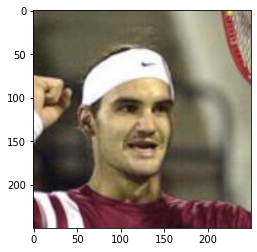

In [203]:
plt.imshow(img2)

In [204]:
inference((img1,img2))

0.8756714165210724
DIFFERENT


# Test with your own images.
Upload your images in Collab and change the name

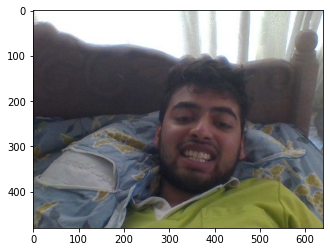

In [236]:
img1 = plt.imread('./4.jpg')
img2 = plt.imread('./2.jpg')
plt.imshow(img1)


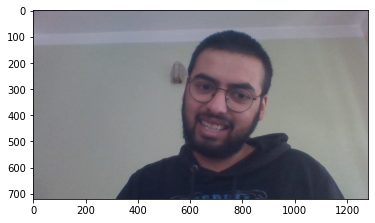

In [237]:
plt.imshow(img2)

In [238]:
inference((img1,img2))

0.6593511700630188
DIFFERENT


# Conclusion
You created basic Face Verification model using Siamese Network. You can further modify this as per your need. 